In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model


In [1]:
from google.colab import files

uploaded = files.upload()

# เช็คว่าไฟล์ถูกอัปโหลดหรือไม่
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes


In [2]:
# ติดตั้ง Kaggle API client
!pip install -q kaggle

# ย้ายไฟล์ kaggle.json ไปยังไดเรกทอรีที่ถูกต้อง
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# ให้ไปดาวน์โหลด URL ของ Dataset จาก Kaggle และนำมาแยกตามไฟล์ที่เป็น zip
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset


 46% 7.00M/15.1M [00:00<00:00, 73.0MB/s]
100% 15.1M/15.1M [00:00<00:00, 124MB/s] 


In [4]:
!pip install tensorflow


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# สร้างโมเดลแบบแรก
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# สร้างโมเดลแบบที่สอง
model3 = Sequential()
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
sgd = SGD(learning_rate=0.01)


In [59]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    'brain_tumor_dataset/brain_tumor_dataset',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    'brain_tumor_dataset/brain_tumor_dataset',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [61]:
history1 = model1.fit(train_generator, epochs=10, validation_data=validation_generator)
history2 = model3.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
7/7 [==============================] - 3s 225ms/step - loss: 0.7888 - accuracy: 0.5567 - val_loss: 0.6714 - val_accuracy: 0.6600
Epoch 2/10
7/7 [==============================] - 2s 225ms/step - loss: 0.5624 - accuracy: 0.7044 - val_loss: 0.5330 - val_accuracy: 0.7400
Epoch 3/10
7/7 [==============================] - 2s 266ms/step - loss: 0.4592 - accuracy: 0.8227 - val_loss: 0.5854 - val_accuracy: 0.7600
Epoch 4/10
7/7 [==============================] - 2s 325ms/step - loss: 0.4203 - accuracy: 0.8276 - val_loss: 0.5432 - val_accuracy: 0.7400
Epoch 5/10
7/7 [==============================] - 2s 213ms/step - loss: 0.3978 - accuracy: 0.8571 - val_loss: 0.5447 - val_accuracy: 0.7800
Epoch 6/10
7/7 [==============================] - 1s 195ms/step - loss: 0.3525 - accuracy: 0.8621 - val_loss: 0.5325 - val_accuracy: 0.7400
Epoch 7/10
7/7 [==============================] - 1s 190ms/step - loss: 0.3045 - accuracy: 0.8621 - val_loss: 0.5521 - val_accuracy: 0.8000
Epoch 8/10
7/7 [====

In [62]:
score1 = model1.evaluate(validation_generator)
score2 = model3.evaluate(validation_generator)

print("Model 1 - Validation Accuracy:", score1[1])
print("Model 2 - Validation Accuracy:", score2[1])


2/2 [==============================] - 0s 83ms/step - loss: 0.6064 - accuracy: 0.6200
Model 1 - Validation Accuracy: 0.8399999737739563
Model 2 - Validation Accuracy: 0.6200000047683716


2/2 [==============================] - 0s 29ms/step


2/2 [==============================] - 0s 86ms/step


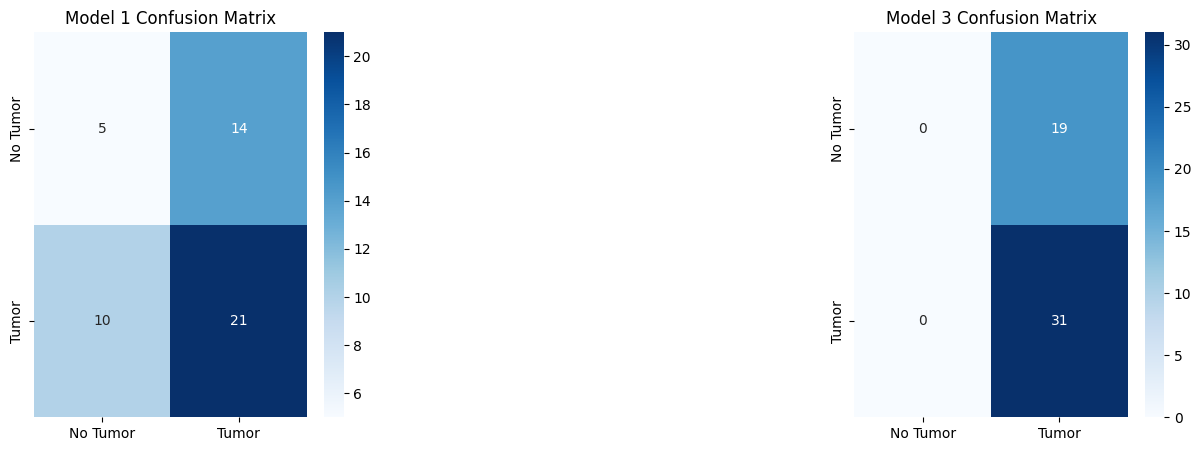

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ทำนายคลาสจากชุดข้อมูลทดสอบ
y_pred1 = (model1.predict(validation_generator) > 0.5).astype("int32")
y_pred3 = (model3.predict(validation_generator) > 0.5).astype("int32")

# ดึงคลาสจริงจากชุดข้อมูลทดสอบ
y_true = validation_generator.classes

# สร้าง confusion matrix
cm1 = confusion_matrix(y_true, y_pred1)
cm3 = confusion_matrix(y_true, y_pred3)

# แสดง confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("Model 1 Confusion Matrix")

plt.subplot(1, 3, 3)
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("Model 3 Confusion Matrix")

plt.show()


In [66]:
# บันทึกโมเดลลงไปยังไฟล์
model1.save('brain_tumor_model1.h5')


In [67]:
from google.colab import files

# ดาวน์โหลดไฟล์โมเดล
files.download('brain_tumor_model1.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
loaded_model = load_model('brain_tumor_model1.h5')
predictions = (loaded_model.predict(validation_generator) > 0.5).astype("int32")


2/2 [==============================] - 0s 44ms/step


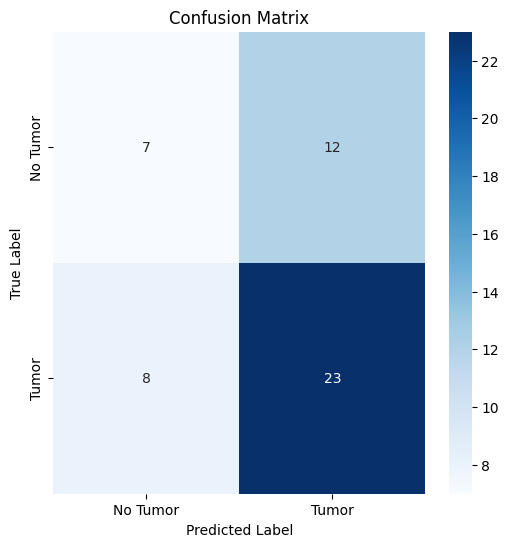

In [69]:
cm = confusion_matrix(y_true, predictions)

# แสดงผลลัพธ์เป็นภาพ
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
